<a href="https://www.kaggle.com/code/enricofindley/spacex-rocket-landing-prediction?scriptVersionId=139583020" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install & Importing Dependencies

In [1]:
# Installing Dependencies
%pip install folium

# Importing Dependencies
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import folium
import pandas as pd
from folium.plugins import MarkerCluster,MousePosition
from folium.features import DivIcon

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Collecting

### There are 2 ways to collect the data:
* API
* Webscraping: https://kaggle.com/code/enricofindley/web-scraping-space-x-falcon-9-data

But in this notebook we will use API from SpaceX to collect data (see webscraping technique from link above)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data:
* From the <code>rocket</code> column we would like to learn the booster name.
* From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.
* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.
* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])
        
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
        
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:

In [3]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

# Request API data and get Response
response = requests.get(spacex_url)

# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())

# Get the head of the dataframe
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.

In [4]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

Now we will get all the data using helper function we already created above.

In [5]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

# Call getBoosterVersion
getBoosterVersion(data)
# Call getLaunchSite
getLaunchSite(data)
# Call getPayloadData
getPayloadData(data)
# Call getCoreData
getCoreData(data)

In [6]:
# Create dictionary to accomodate the data parsed
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

# Create a data from launch_dict
launch_df = pd.DataFrame.from_dict(launch_dict)
# Show the head of the dataframe
launch_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


### Next we have to do this task below to make this data to be useable:
* Filter the dataframe to only include `Falcon 9` launches
* Dealing with missing values

In [7]:
# Filter the dataframe to only include Faclon 9
data_falcon9 = launch_df[launch_df['BoosterVersion']!='Falcon 1']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))

# Replace missing value
# Calculate the mean value of PayloadMass column
mean = data_falcon9['PayloadMass'].mean()
# Replace the np.nan values with its mean value with replace() function
data_falcon9['PayloadMass'].replace(np.nan, mean, inplace=True)
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.000000,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


# Data Wrangling

### This step is for preparing training label

In [8]:
# Identify and calculate the percentage of the missing values in each attribute
print(data_falcon9.isnull().sum()/data_falcon9.count()*100)
print("\n")
# Identify which columns are numerical and categorical:
print(data_falcon9.dtypes)

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64


FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object


In [9]:
# Use the method .value_counts() on the column LaunchSite to determine the number of launches on each site: 
print(data_falcon9['LaunchSite'].value_counts(), "\n")

# Use the method .value_counts() to determine the number and occurrence of each orbit in the  column Orbit
print(data_falcon9['Orbit'].value_counts(),"\n")

# Use the method .value_counts() on the column Outcome to determine the number of landing_outcomes.
landing_outcomes = data_falcon9['Outcome'].value_counts()
print(landing_outcomes)

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64 

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64 

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64


<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.

Now lets see the index of each landing outcome

In [10]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [11]:
# calculate landing_outcomes_percentage that success only
landing_outcomes_percentage = landing_outcomes/data_falcon9['Outcome'].count()*100
print("Success Percentage:",landing_outcomes_percentage[0]+landing_outcomes_percentage[2]+landing_outcomes_percentage[4])

Success Percentage: 66.66666666666667


We create a set of outcomes where the second stage did not land successfully and then make the label for training <code>Class</code>

In [12]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
data_falcon9['Class']=data_falcon9['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)
data_falcon9.head()

# Save data for used later as label for machine learning models
data_label = data_falcon9

# Exploratory Data Analysis

### We are going to do task below to explore the data:
* Data visualization using matplotlib, seaborn, and folium
* Analysis each visualization

#### Folium Visualization

First we select relevant sub-colums first to feed the data to folium library.

In [13]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = data_falcon9[['LaunchSite', 'Latitude', 'Longitude', 'Class']]
launch_sites_df = spacex_df.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]
launch_sites_df

,LaunchSite,Latitude,Longitude
0,CCSFS SLC 40,28.561857,-80.577366
1,KSC LC 39A,28.608058,-80.603956
2,VAFB SLC 4E,34.632093,-120.610829


Next we have to determine the start location when map is loading, in this case we choose nasa coordinate location.

In [14]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for index, row in launch_sites_df.iterrows():
    circle = folium.Circle([row['Latitude'], row['Longitude']], radius=1000, color='#d35400', fill=True).add_child(folium.Popup(row['LaunchSite']))
    marker = folium.map.Marker(
        [row['Latitude'], row['Longitude']],
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % row['LaunchSite'],
            )
        )
    site_map.add_child(marker)
    site_map.add_child(circle)
site_map

**Now, you can explore the map by zoom-in/out the marked areas, the marked location shows that the launch sites is nearing the coast.**

Next thing to do is we are going to mark the successful and failed launches for each sites.

In [15]:
marker_cluster = MarkerCluster()
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
# assign marker color which red is failed launch and green is successful launches   
spacex_df['marker_color'] = spacex_df['Class'].apply(assign_marker_color)

# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    marker = folium.Marker([record['Latitude'], record['Longitude']], icon=folium.Icon(color='white', icon_color=record['marker_color']))
    
    marker_cluster.add_child(marker)

site_map

Now try zoomed in and we can see from the color-labeled markers in marker clusters, you should be able to easily identify which launch sites have relatively high success rates.

Next we are going to calculate and draw distance between launches sites and its proximities.

In [16]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)
site_map.add_child(mouse_position)
site_map

Now u can see the coordinate of mouse when hovered on map showed on top right of the map.

Next try open notepad and write down the coordinate of launches sites and the nearest coastlines, in this case i use coordinates of KSC LC 39A launch sites.

But first we have to define function to help us calculate the distance between launch sites and the coastlines.

In [17]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance
# first element is the coordinate of the launches sites and the second is coordinate of the coastlines
coordinates = [[28.60807,-80.60395],[28.61227,-80.59736]]
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
distance_coastline = calculate_distance(coordinates[0][0],coordinates[0][1],coordinates[1][0],coordinates[1][1])
print(distance_coastline)

0.7951980089408613


In [18]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
# for examp
distance_marker = folium.Marker(
    coordinates[1],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 64; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
        )
    )
site_map.add_child(distance_marker)

As u zoomed in u can see the red colored text that show the distance between the launches sites and the nearest coastlines. But its still missing adding the lines so we can view it more easily.

In [19]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
lines=folium.PolyLine(locations=coordinates, weight=5)
site_map.add_child(lines)

Now we can see it more clearly, now since the launch sites supposed to be in close proximity to railways, highways and coastline, but not close to cities, next step is we are going to draw the lines between the launch sites and the nearest railways, highways and coastline.

A railway map symbol may look like this:
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/railway.png">
</center>

A highway map symbol may look like this:
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/highway.png">
</center>

A city map symbol may look like this:
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/city.png">
</center>

In [20]:
coordinate_dict = {
    'launch_site': coordinates[0],
    'city': [28.4011,-80.60489], # Cape Canaveral coordinates
    'highway': [28.60919,-80.59673],
    'railway': [28.61352, -80.59954]
}

# Calculating distance
distance_city = calculate_distance(coordinate_dict['launch_site'][0], coordinate_dict['launch_site'][1], coordinate_dict['city'][0], coordinate_dict['city'][1])
distance_highway = calculate_distance(coordinate_dict['launch_site'][0], coordinate_dict['launch_site'][1], coordinate_dict['highway'][0], coordinate_dict['highway'][1])
distance_railway = calculate_distance(coordinate_dict['launch_site'][0], coordinate_dict['launch_site'][1], coordinate_dict['railway'][0], coordinate_dict['railway'][1])

print(distance_city)
print(distance_highway)
print(distance_railway)

23.021421940002664
0.7159537909978753
0.7435867620284439


Draw marker

In [21]:
# Create a marker with distance to a closest city, railway, highway, etc.
# Draw a line between the marker to the launch site
# Display the distance on the marker
city_marker = folium.Marker(
    [coordinate_dict['city'][0], coordinate_dict['city'][1]],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_city),
        )
    )
highway_marker = folium.Marker(
    [coordinate_dict['highway'][0], coordinate_dict['highway'][1]],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_highway),
        )
    )
railway_marker = folium.Marker(
    [coordinate_dict['railway'][0], coordinate_dict['railway'][1]],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_railway),
        )
    )
site_map.add_child(city_marker)
site_map.add_child(highway_marker)
site_map.add_child(railway_marker)

Draw lines

In [22]:
city_lines=folium.PolyLine(locations=[[coordinate_dict['launch_site'][0], coordinate_dict['launch_site'][1]],[coordinate_dict['city'][0], coordinate_dict['city'][1]]], weight=5, color='red')
highway_lines=folium.PolyLine(locations=[[coordinate_dict['launch_site'][0], coordinate_dict['launch_site'][1]],[coordinate_dict['highway'][0], coordinate_dict['highway'][1]]], weight=5, color='green')
railway_lines=folium.PolyLine(locations=[[coordinate_dict['launch_site'][0], coordinate_dict['launch_site'][1]],[coordinate_dict['railway'][0], coordinate_dict['railway'][1]]], weight=5, color='gray')
site_map.add_child(city_lines)
site_map.add_child(highway_lines)
site_map.add_child(railway_lines)

Now we can see all distances that we need.

# Feature Engineering

**In this part we are going to prepare the feature for machine learning model we are going to implement:**
* First we are going to visually analyze first the relationship between feature except latitude and longitude which we are already analyzed.
* Then we do feature engineering.

First, let's try to see how the `FlightNumber` (indicating the continuous launch attempts.) and `Payload` variables would affect the launch outcome.

We can plot out the <code>FlightNumber</code> vs. <code>PayloadMass</code>and overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.


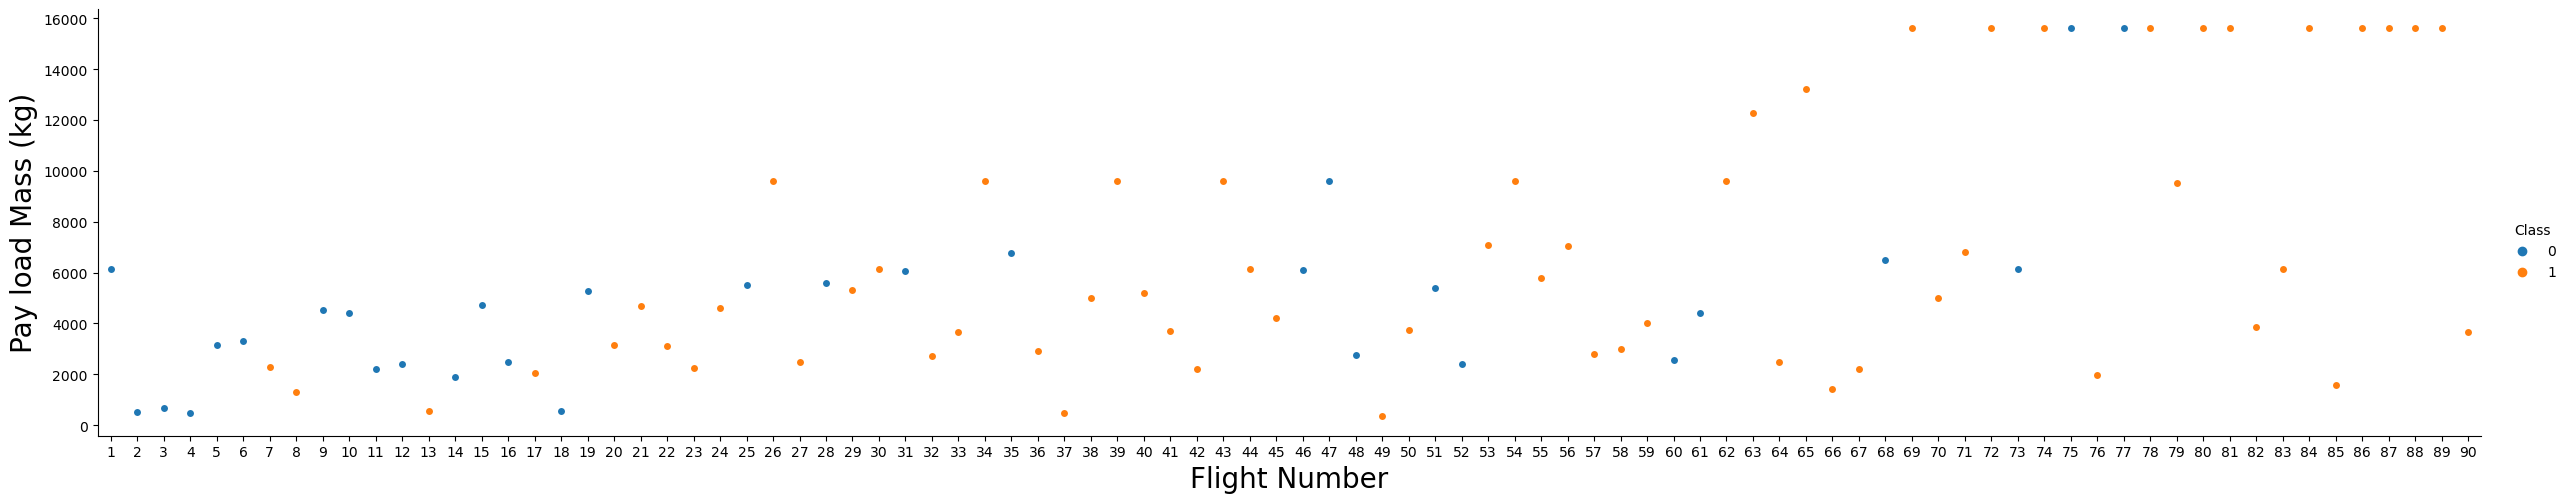

In [23]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

We see that different launch sites have different success rates.  <code>CCAFS LC-40</code>, has a success rate of 60 %, while  <code>KSC LC-39A</code> and <code>VAFB SLC 4E</code> has a success rate of 77%. Next, let's drill down to each site visualize its detailed launch records.

Use the function <code>catplot</code> to plot <code>FlightNumber</code> vs <code>LaunchSite</code>, set the  parameter <code>x</code>  parameter to <code>FlightNumber</code>,set the  <code>y</code> to <code>Launch Site</code> and set the parameter <code>hue</code> to <code>'class'</code>

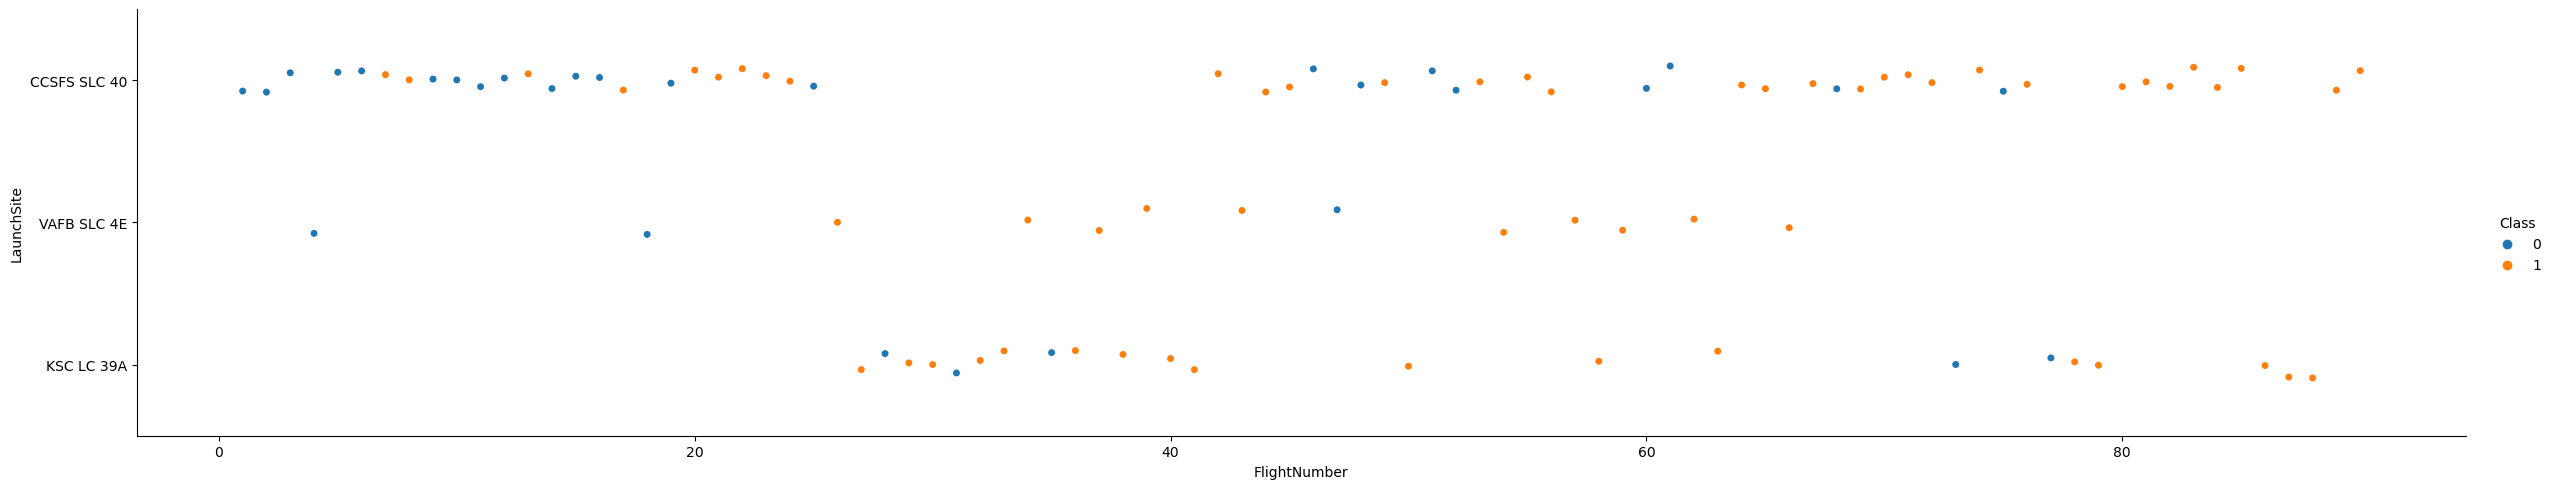

In [24]:
# Plot a scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(x="FlightNumber", y="LaunchSite", hue="Class", data=data_falcon9, aspect = 5)

As the flight number is increasing, the success rate is increasing as well. The success rate is higher in CCAFS LC-40 and VAFB SLC 4E than KSC LC-39A.

We also want to observe if there is any relationship between launch sites and their payload mass.

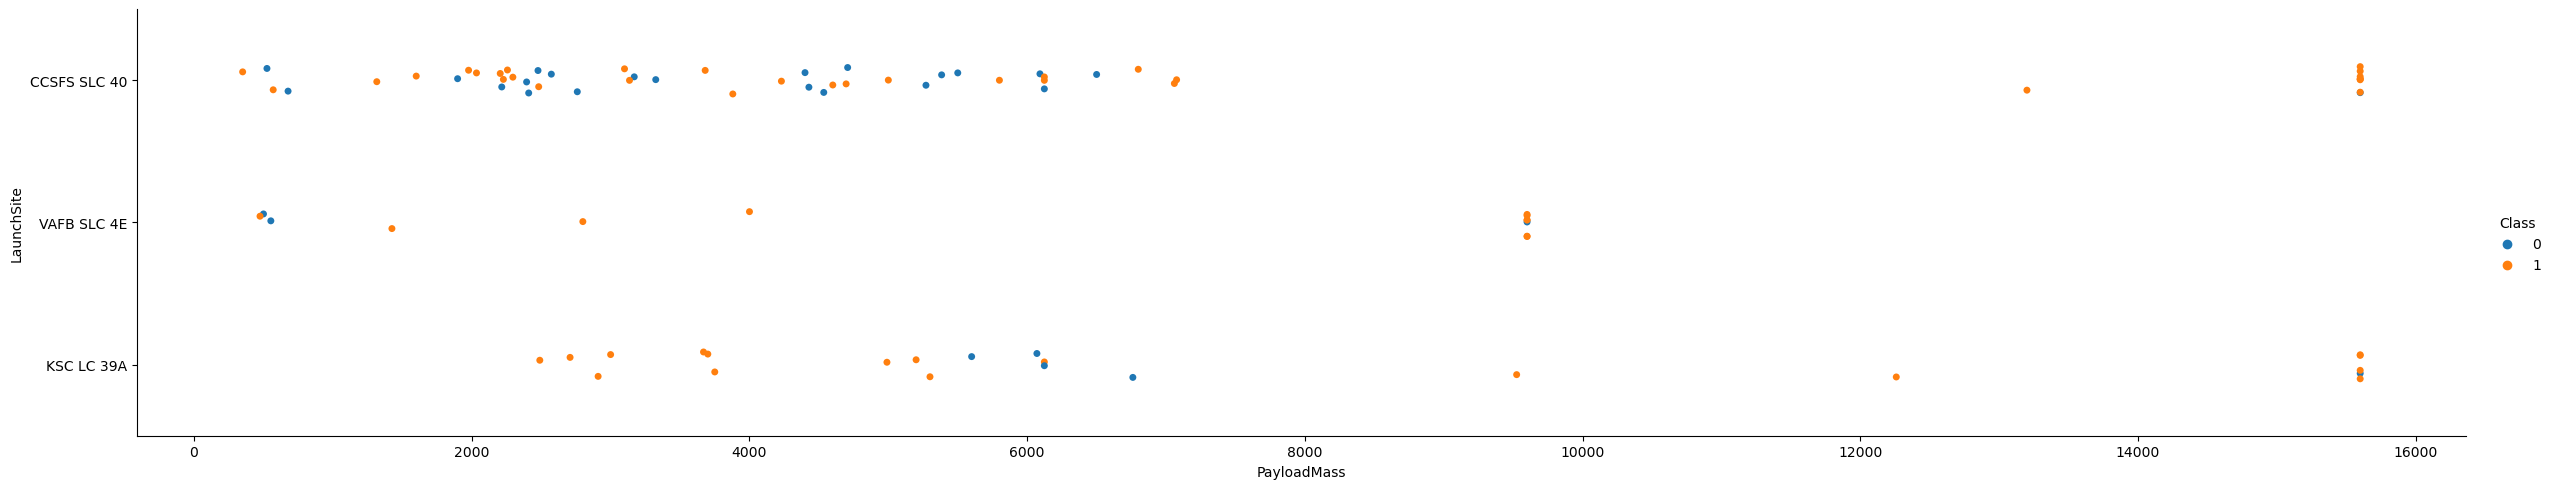

In [25]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(x="PayloadMass", y="LaunchSite", hue="Class", data=data_falcon9, aspect = 5)

Now if you observe Payload Vs. Launch Site scatter point chart you will find for the VAFB-SLC  launchsite there are no  rockets  launched for  heavypayload mass(greater than 10000).


Next, we want to visually check if there are any relationship between success rate and orbit type.


<Axes: xlabel='Orbit', ylabel='Success Rate'>

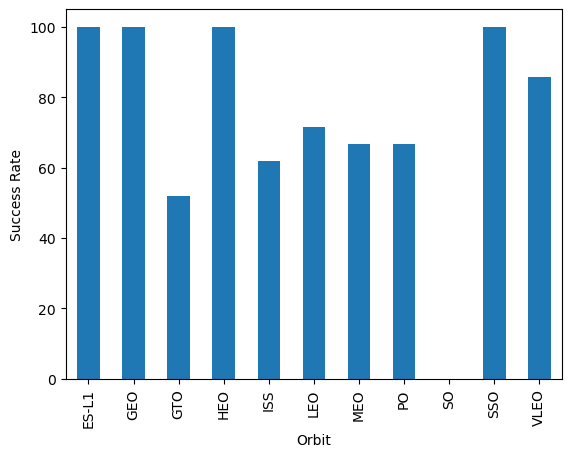

In [26]:
# Visualize the relationship between success rate of each orbit type using a bar chart
(data_falcon9.groupby(['Orbit'])['Class'].mean()*100).plot(kind='bar', ylabel='Success Rate', xlabel='Orbit')

Orbit ES-L1, GEO, HEO, and SSO is the orbit with highest success rates. 

For each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.


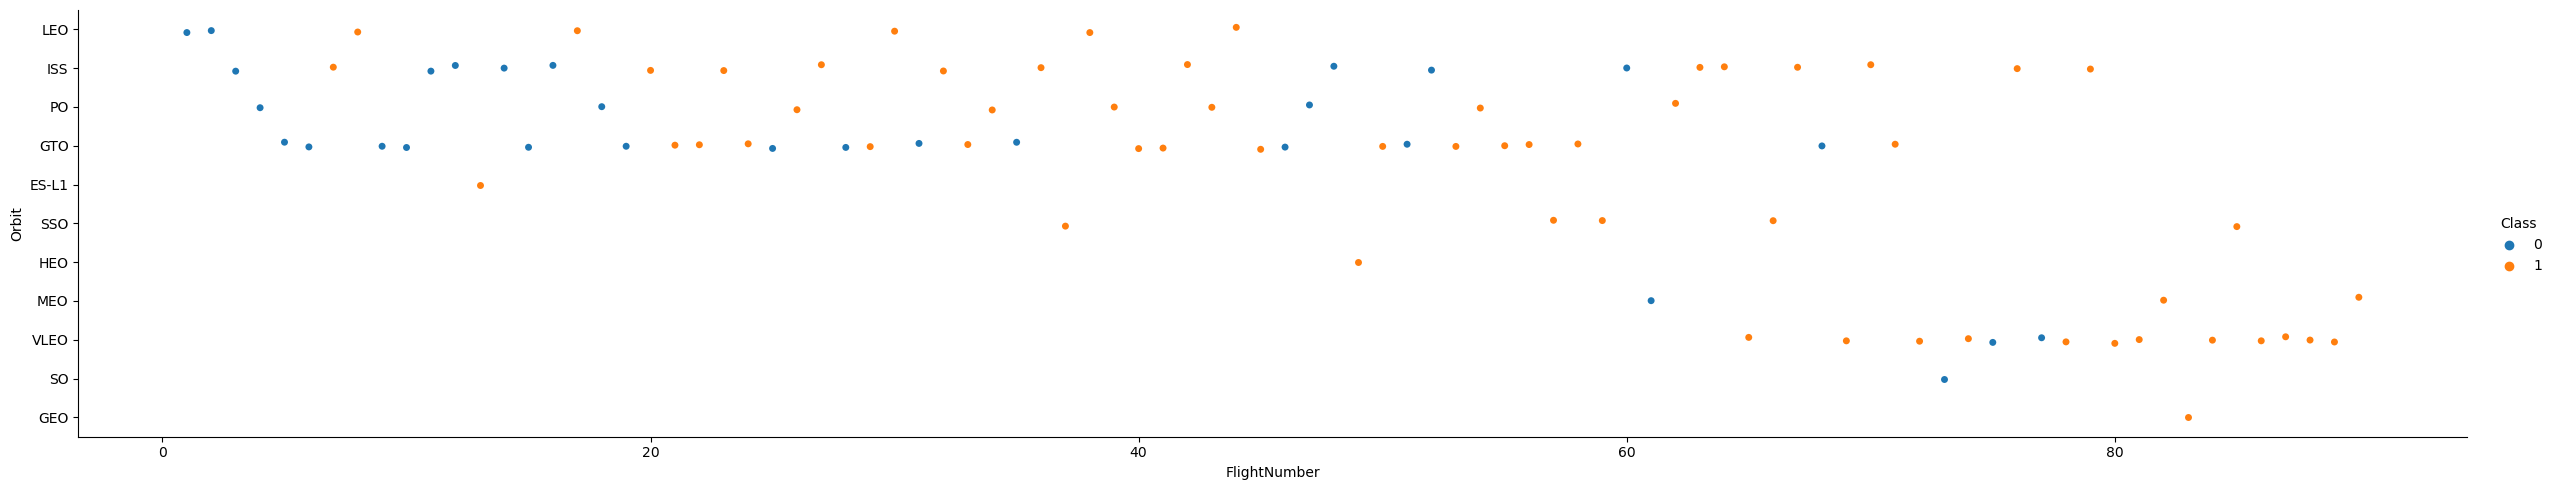

In [27]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(x="FlightNumber", y="Orbit", hue="Class", data=data_falcon9, aspect = 5)

You should see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.

Similarly, we can plot the Payload vs. Orbit scatter point charts to reveal the relationship between Payload and Orbit type


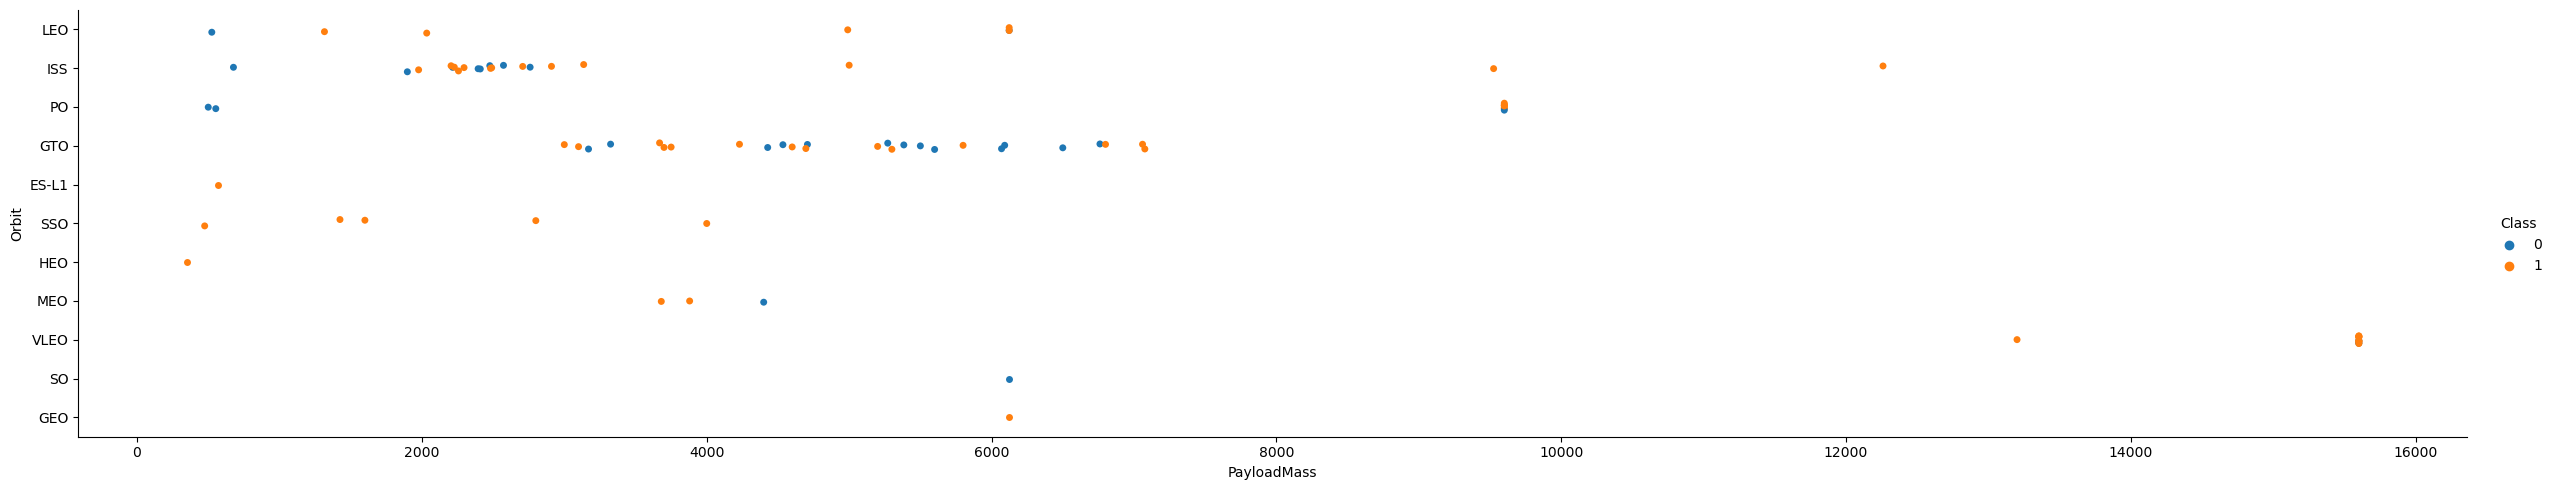

In [28]:
# Plot a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value
sns.catplot(x="PayloadMass", y="Orbit", hue="Class", data=data_falcon9, aspect = 5)

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.   

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

Visualize the launch success yearly trend with plot a line chart with x axis to be <code>Year</code> and y axis to be average success rate, to get the average launch success trend. 

<Axes: xlabel='Year', ylabel='Success Rate'>

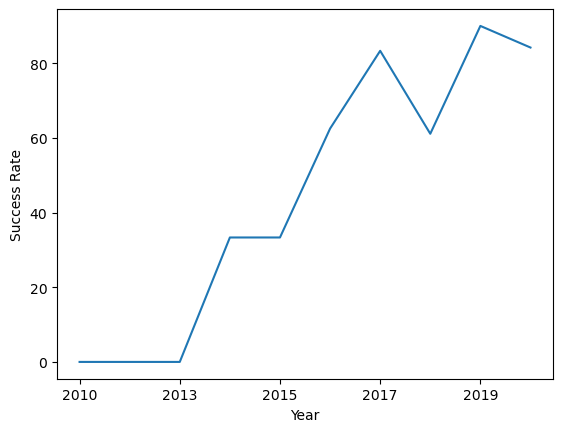

In [29]:
# A function to Extract years from the date 
year=[]
def Extract_year(date):
    for i in data_falcon9["Date"]:
        year.append(i.strftime("%Y"))
    return year
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
data_falcon9["year"]=Extract_year(data_falcon9["Date"])
(data_falcon9.groupby(['year'])['Class'].mean()*100).plot(kind='line', ylabel='Success Rate', xlabel='Year')

You can observe that the sucess rate since 2013 kept increasing till 2020


Finally we are going to engineered the feature before we can feed it to our machine learning models.

By now, you should obtain some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction in the future module.


In [30]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


Use the function <code>get_dummies</code> and <code>features</code> dataframe to apply OneHotEncoder to the column <code>Orbits</code>, <code>LaunchSite</code>, <code>LandingPad</code>, and <code>Serial</code>. Assign the value to the variable <code>features_one_hot</code>, display the results using the method head.

In [31]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now that our <code>features_one_hot</code> dataframe only contains numbers cast the entire dataframe to variable type <code>float64</code>

In [32]:
features_one_hot = features_one_hot.astype('float64')

# Model Training and Testing

## In this part we are going to do these steps:
* Data Pre-processing such as transformation, normalization, and data splitting
* Training model
* Testing model

Define function to plot confusion matrix and load the feature and label

In [33]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show()

X = features_one_hot
Y = data_label['Class'].to_numpy()
X.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalize the feature and do splitting data into training and testing dataset

In [34]:
# Normalize
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

**Train 4 machine learning model with hyperparameter tuning with GridSearch CV algorithm (logistic regression, SVM, decision tree, and KNN), after training plot the confusion matrix.**

**Logistic Regression**

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714
Testing Accuracy 0.8333333333333334


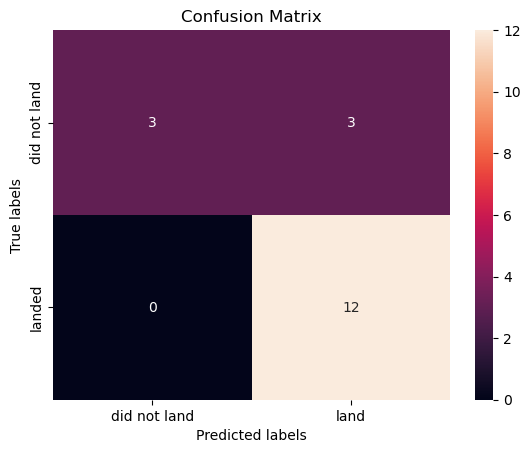

In [35]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}
LR = LogisticRegression()
logreg_cv = GridSearchCV(LR, cv=10, param_grid=parameters)
logreg_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

print("Testing Accuracy", logreg_cv.score(X_test, Y_test))

yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

**SVM (Support Vector Machine)**

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858
Testing Accuracy 0.8333333333333334


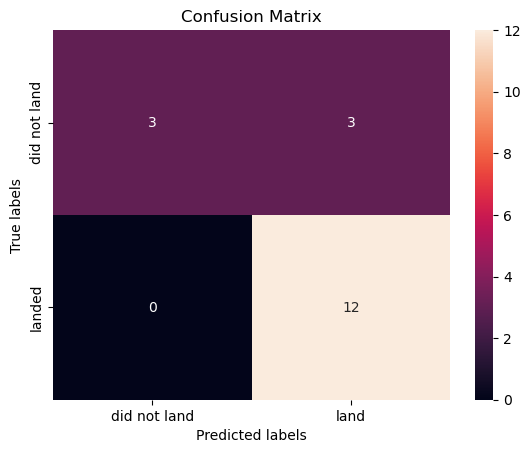

In [36]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(svm, cv=10, param_grid=parameters)
svm_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

print("Testing Accuracy", svm_cv.score(X_test, Y_test))

yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

**Decision Tree**

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.8625
Testing Accuracy 0.8333333333333334


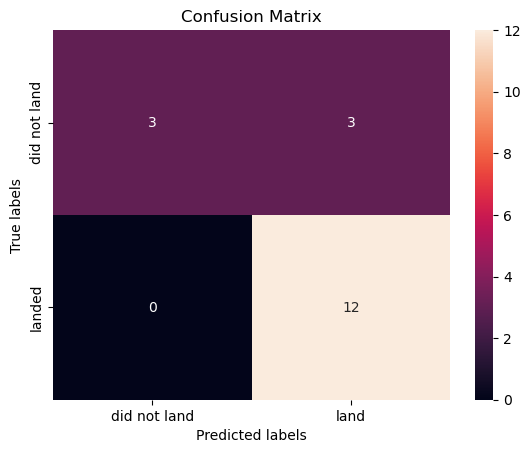

In [37]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, cv=10, param_grid=parameters)
tree_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

print("Testing Accuracy", tree_cv.score(X_test, Y_test))

yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

KNN (K-Nearest Neighbors)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714
Testing Accuracy 0.7777777777777778


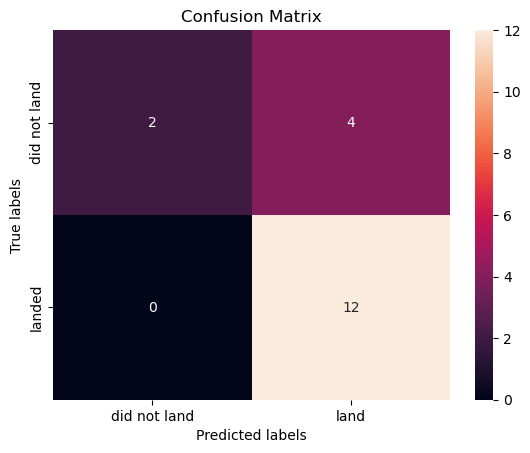

In [38]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, cv=10, param_grid=parameters)
knn_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

print("Testing Accuracy", knn_cv.score(X_test, Y_test))

yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

**Comparing each result**

In [39]:
print("Model\t\tAccuracy\tTestAccuracy")
print("LogReg\t\t{}\t\t{}".format((logreg_cv.best_score_).round(5), logreg_cv.score(X_test, Y_test).round(5)))
print("SVM\t\t{}\t\t{}".format((svm_cv.best_score_).round(5), svm_cv.score(X_test, Y_test).round(5)))
print("Tree\t\t{}\t\t{}".format((tree_cv.best_score_).round(5), tree_cv.score(X_test, Y_test).round(5)))
print("KNN\t\t{}\t\t{}".format((knn_cv.best_score_).round(5), knn_cv.score(X_test, Y_test).round(5)))

comparison = {}

comparison['LogReg'] = {'Accuracy': logreg_cv.best_score_.round(5), 'TestAccuracy': logreg_cv.score(X_test, Y_test).round(5)}
comparison['SVM'] = {'Accuracy': svm_cv.best_score_.round(5), 'TestAccuracy': svm_cv.score(X_test, Y_test).round(5)}
comparison['Tree'] = {'Accuracy': tree_cv.best_score_.round(5), 'TestAccuracy': tree_cv.score(X_test, Y_test).round(5)}
comparison['KNN'] = {'Accuracy': knn_cv.best_score_.round(5), 'TestAccuracy': knn_cv.score(X_test, Y_test).round(5)}

Model		Accuracy	TestAccuracy
LogReg		0.82143		0.83333
SVM		0.84821		0.83333
Tree		0.8625		0.83333
KNN		0.83393		0.77778


# Conclusion
### It seems from 4 model we trained the model that best used for predicting if rocket landing success or not are the logistic regression model or support vector machine